In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from tensorflow.keras import layers, models, optimizers
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import os


In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

movies = movies.merge(credits, on='title')
movies = movies[['id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.dropna(inplace=True)

print(f"Loaded {len(movies)} movies successfully.")
movies.head()

Loaded 4806 movies successfully.


,id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [3]:
import ast

def clean_column(x):
    try:
        return " ".join([i['name'] for i in ast.literal_eval(x)])
    except:
        return ""

movies['genres'] = movies['genres'].apply(clean_column)
movies['keywords'] = movies['keywords'].apply(clean_column)
movies['cast'] = movies['cast'].apply(lambda x: " ".join([i['name'] for i in ast.literal_eval(x)[:3]]))
movies['crew'] = movies['crew'].apply(lambda x: " ".join([i['name'] for i in ast.literal_eval(x) if i['job'] == 'Director']))

movies['tags'] = (
    movies['overview'] + " " +
    movies['genres'] + " " +
    movies['keywords'] + " " +
    movies['cast'] + " " +
    movies['crew']
)

movies = movies[['id', 'title', 'tags']]
print(" Text preprocessing complete!")
movies.sample(5)


 Text preprocessing complete!


,id,title,tags
3740,10246,Porky's,"Set in 1954, a group of Florida high schoolers..."
87,158852,Tomorrowland,"Bound by a shared destiny, a bright, optimisti..."
4591,19204,The Beyond,A young woman inherits an old hotel in Louisia...
1930,64639,Straw Dogs,L.A. screenwriter David Sumner relocates with ...
4248,30082,Forty Shades of Blue,A Russian woman living in Memphis with a much ...


In [4]:
print("Generating embeddings using Sentence-BERT...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(movies['tags'].tolist(), show_progress_bar=True)
embeddings = np.array(embeddings)

print(f"Embedding shape: {embeddings.shape}")



Generating embeddings using Sentence-BERT...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Embedding shape: (4806, 384)


Visualizing sample embeddings with t-SNE...


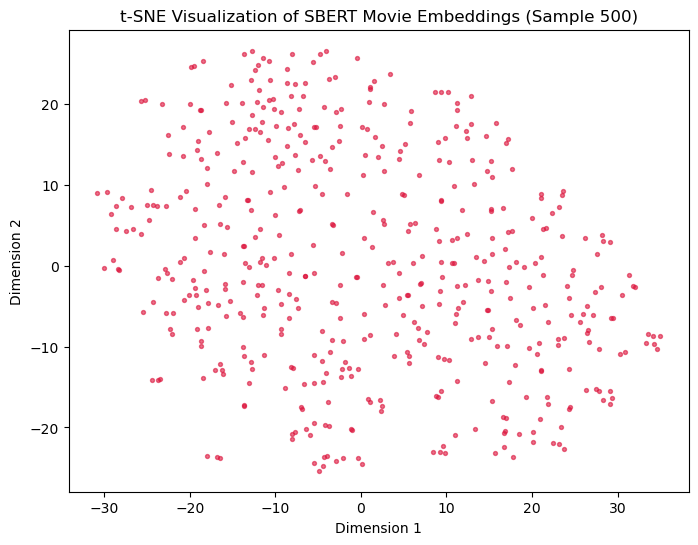

In [5]:
print("Visualizing sample embeddings with t-SNE...")
sample_embeddings = embeddings[:500]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(sample_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], s=8, alpha=0.6, c='crimson')
plt.title("t-SNE Visualization of SBERT Movie Embeddings (Sample 500)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [14]:
from tensorflow.keras import Input, Model, layers, optimizers

input_dim = embeddings.shape[1]

# Input Layer
inp = Input(shape=(input_dim,))

# Encoder
x = layers.Dense(512, activation='relu')(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
latent = layers.Dense(128, activation='relu', name='latent_layer')(x)

# Decoder
x = layers.Dense(256, activation='relu')(latent)
x = layers.Dense(512, activation='relu')(x)
out = layers.Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=inp, outputs=out)
encoder = Model(inputs=inp, outputs=latent)

autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_layer (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 384)            │       196,992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,992 (2.77 MB)

 Trainable params: 723,968 (2.76 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

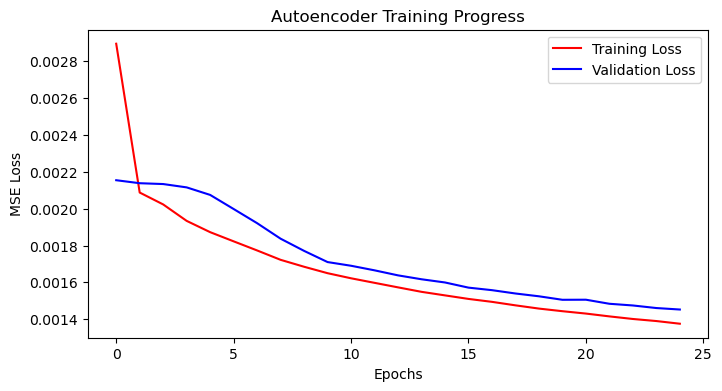

In [15]:
history = autoencoder.fit(
    embeddings, embeddings,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Autoencoder Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
Latent feature space shape: (4806, 128)


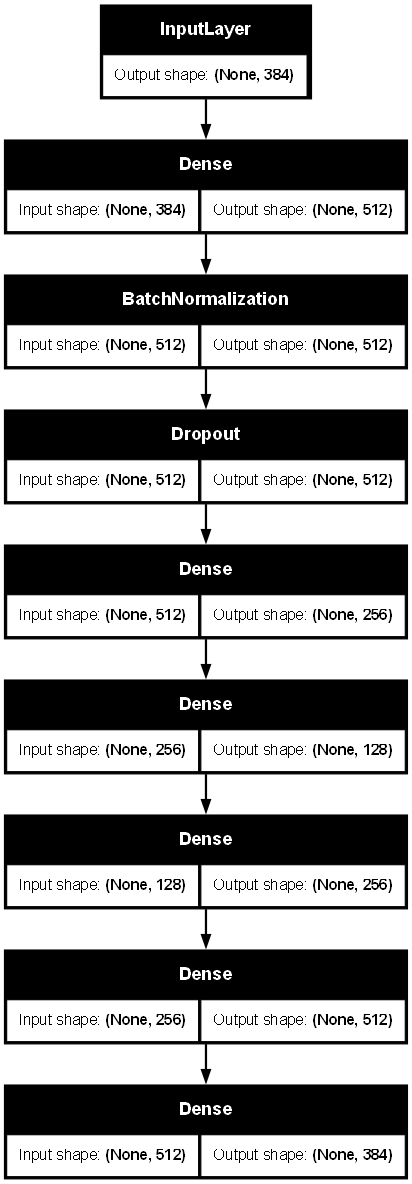

In [18]:
latent_features = encoder.predict(embeddings)
print(f"Latent feature space shape: {latent_features.shape}")

from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder_structure.png', show_shapes=True, dpi=80)


In [19]:
similarity = cosine_similarity(latent_features)
print("Cosine similarity matrix computed.")



Cosine similarity matrix computed.


In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

subset_idx = np.random.choice(latent_features.shape[0], 2000, replace=False)
sample_latent = latent_features[subset_idx]

kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
labels = kmeans.fit_predict(sample_latent)

sil_score = silhouette_score(sample_latent, labels)
print(f" Silhouette Score (latent space): {sil_score:.3f}")


 Silhouette Score (latent space): 0.063


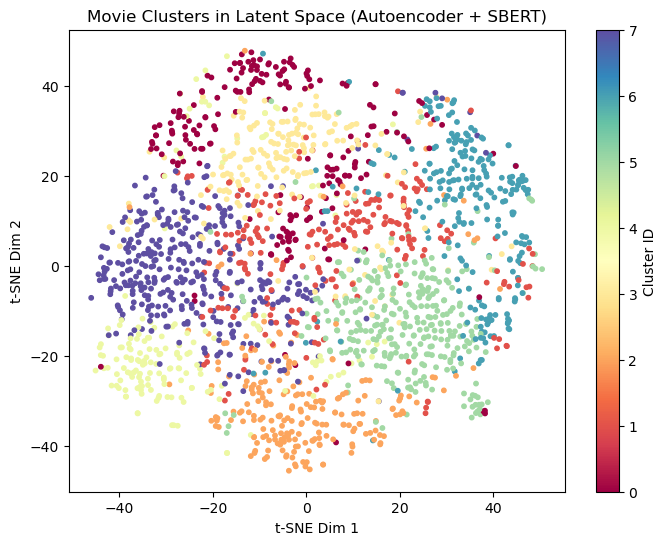

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(sample_latent)

plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='Spectral', s=10)
plt.title("Movie Clusters in Latent Space (Autoencoder + SBERT)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(label='Cluster ID')
plt.show()


In [28]:
os.makedirs('artifacts', exist_ok=True)

pickle.dump(movies.to_dict(), open('movie_dict2.pkl', 'wb'))
pickle.dump(similarity, open('similarity2.pkl', 'wb'))
autoencoder.save('deep_autoencoder2.h5')
encoder.save('encoder_model.h5')

print("All artifacts saved successfully inside /artifacts folder.")


All artifacts saved successfully inside /artifacts folder.


In [30]:
def recommend(movie_title, movies_df, sim_matrix, top_n=5):
    try:
        index = movies_df[movies_df['title'].str.lower() == movie_title.lower()].index[0]
    except:
        print("❌ Movie not found!")
        return
    distances = sorted(list(enumerate(sim_matrix[index])), reverse=True, key=lambda x: x[1])[1:top_n+1]
    print(f"\n🎥 Top {top_n} recommendations for: {movie_title}\n")
    for i, d in distances:
        print(f"{movies_df.iloc[i].title}  —  Similarity: {d:.3f}")

recommend("Interstellar", movies, similarity)



🎥 Top 5 recommendations for: Interstellar

The Inhabited Island  —  Similarity: 0.907
Tomorrowland  —  Similarity: 0.905
Lost in Space  —  Similarity: 0.903
Red Planet  —  Similarity: 0.889
The Martian  —  Similarity: 0.887


C:\Users\Harshit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


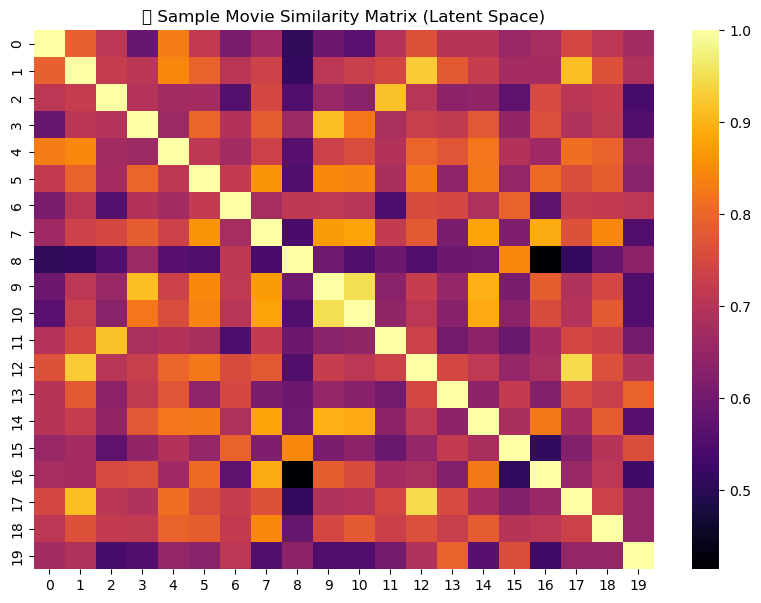